In [3]:
# load libraries for data processing
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import chemometrics as cm
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from chemometrics.mcr import McrAR
import chemometrics.mcr.constraint as constraint
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.extmath import randomized_svd
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# Get CSV files list from a folder
path = 'f:/GAC_KSY/spectrum/1_amaranth/data/NIR_Gachon_amaranth'
mat_files = glob.glob(path + "/*.xlsx")
df_list = [pd.read_excel(file) for file in mat_files]
df = pd.concat(df_list, ignore_index=False, axis = 1, join = "outer")
# import data into dict
data = {}
for file in mat_files:
    data[file.split("/")[-1].replace(".xlsx","").replace('NIR_Gachon_amaranth\\Gachon_','')] = pd.read_excel(file, index_col=0)

In [25]:
#refl = [df["Cm-1"].iloc[:,0]]
wl = pd.Series(df["Cm-1"].to_numpy().ravel(order="K"), name="ref")

In [42]:
df["Cm-1"]
raw_df = df
df.drop(columns = 'Cm-1')

,E46_res32_001_230428_104059.0000,E46_res32_001_230428_104059.0001,E46_res32_001_230428_104059.0002,E47_res32_001_230428_105353.0000,E47_res32_001_230428_105353.0001,E47_res32_001_230428_105353.0002,O46_res32_001_230428_103400.0000,O46_res32_001_230428_103400.0001,O46_res32_001_230428_103400.0002,O47_res32_001_230428_104409.0000,...,E096_230612_140148.0002,E097_230612_105205.0000,E097_230612_105205.0001,E097_230612_105205.0002,E098_230612_134546.0000,E098_230612_134546.0001,E098_230612_134546.0002,E099_230612_102805.0000,E099_230612_102805.0001,E099_230612_102805.0002
0,0.121523,0.121405,0.121640,0.121868,0.122461,0.122244,0.118565,0.118703,0.118586,0.121142,...,0.080352,0.074843,0.074435,0.073228,0.065643,0.063586,0.063194,0.162471,0.159963,0.160196
1,0.121347,0.121314,0.121452,0.121796,0.122201,0.122068,0.118740,0.118660,0.118654,0.121138,...,0.077482,0.072166,0.071755,0.071668,0.061836,0.060386,0.060514,0.160218,0.156927,0.158835
2,0.121076,0.120975,0.121084,0.121387,0.121861,0.121773,0.118717,0.118434,0.118551,0.120937,...,0.075897,0.070273,0.069396,0.070066,0.059051,0.057953,0.058589,0.158070,0.154932,0.157877
3,0.120820,0.120503,0.120659,0.120852,0.121499,0.121332,0.118315,0.118075,0.118219,0.120508,...,0.076039,0.070577,0.068979,0.069447,0.058847,0.057704,0.058680,0.157194,0.155207,0.158247
4,0.120748,0.120305,0.120461,0.120614,0.121411,0.121032,0.117992,0.117877,0.118053,0.120211,...,0.076149,0.071938,0.070564,0.069569,0.060002,0.058691,0.059890,0.157546,0.156293,0.159308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.519280,0.519421,0.519507,0.472979,0.473162,0.473092,0.496362,0.496155,0.496199,0.465671,...,0.510427,0.668539,0.667671,0.668592,0.545399,0.545709,0.546074,0.773037,0.774019,0.773551
456,0.512668,0.512835,0.512946,0.468480,0.468720,0.468616,0.491296,0.491132,0.491154,0.461274,...,0.505805,0.661290,0.660395,0.661325,0.539620,0.539878,0.540593,0.766364,0.767266,0.767136
457,0.505547,0.505721,0.505867,0.463461,0.463725,0.463628,0.485448,0.485285,0.485309,0.456054,...,0.500474,0.653435,0.652562,0.653612,0.533630,0.533669,0.534620,0.759134,0.759616,0.759932
458,0.498406,0.498557,0.498740,0.458382,0.458616,0.458543,0.479078,0.478915,0.478950,0.450252,...,0.495005,0.645745,0.644904,0.646125,0.527695,0.527547,0.528580,0.751772,0.751993,0.752301


Band resampling
특정 센서로 측정된 스펙트럼을 다른 센서로 수집한 스펙트럼과 비교하려면 스펙트럼을 공통 대역 이산화로 리샘플링해야 하는 경우가 많습니다. 단일 센서의 스펙트럼 대역은 시간이 지남에 따라 충분히 표류할 수 있으므로 서로 다른 날짜에 동일한 센서에서 수집된 스펙트럼에는 리샘플링이 필요합니다.

리샘플링을 위해 SPy는 센서를 각 스펙트럼 대역에 대해 가우스 스펙트럼 응답 함수를 갖는 것으로 취급합니다. 소스 센서 대역은 두 대역 응답 함수의 FWHM 사이에 중첩이 있는 모든 대상 대역에 기여합니다. 중첩이 있는 경우 소스 대역 데이터 값이 해당 FWHM에 대해 일정하고(소스 대역에 대한 실제 스펙트럼 로드를 모르기 때문에) 대상 대역에 가우스 응답 함수가 있다고 가정하고 중첩 영역에 대해 적분이 수행됩니다. . 겹치는 소스 대역이 없는 모든 대상 대역은NaN 리샘플링된 밴드 값으로 사용됩니다. 센서 대역에 대한 FWHM 정보를 사용할 수 없는 경우 각 대역의 FWHM은 인접 대역 거리의 절반에 도달하는 것으로 가정됩니다. 리샘플링 결과는 소스 밴드가 대상 밴드보다 더 높은 스펙트럼 해상도에 있을 때 더 좋습니다.

BandResamplerBandResampler 개체를 생성하려면 각 센서에 대한 개체나 밴드 중심 목록 및 선택적으로 FWHM 값 목록을 전달할 수 있습니다 . BandResampler가 생성되면 소스 센서 스펙트럼으로 이를 호출할 수 있으며 리샘플링된 스펙트럼을 반환합니다.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from sklearn.utils.extmath import randomized_svd


def plot_colored_series(Y, x=None, reference=None):
    r"""
    Plot lines colored by position or `reference`

    Generate a line plot with `x` on x-axis and one or multiple dataseries
    `Y`. The lines are either colored by position in the matrix `Y` or by
    value in the `reference` matrix.

    Parameters
    ----------
    Y : (n, m) ndarray
        Matrix containing data series to plot. The function expects. `n`
        datapoints in `m` series.
    x : {None, (n,) ndarray}
        Location on x-axis
    reference : {None (default), (m,) ndarray}
        Reference values to color data series by. If None, the series are
        colored by the position in the second dimension of matrix `Y`.

    Returns
    -------
    lines : list
        A list of line objects generated by plotting the spectra.
    """
    # define number of input series for line plot
    if (Y.ndim > 1):
        n_series = Y.shape[1]
    else:
        n_series = 1
    if x is None:
        x = np.arange(Y.shape[0])
    # if no reference is given a dummy reference is needed (sequential
    # coloring)
    if reference is None:
        reference = np.arange(n_series)
    myMapper = matplotlib.cm.ScalarMappable(cmap='viridis')
    colors = myMapper.to_rgba(reference)
    lines = []
    for i in range(n_series):
        line_i = plt.plot(x, Y[:, i], color=colors[i, :])
        lines.append(line_i[0])
    return lines


In [4]:
# Get CSV files list from a folder
path = 'f:/GAC_KSY/spectrum/1_amaranth/data/NIR_Gachon_amaranth'
mat_files = glob.glob(path + "/*.xlsx")
df_list = [pd.read_excel(file) for file in mat_files]
df = pd.concat(df_list, ignore_index=False, axis = 1, join = "outer")
# import data into dict
data = {}
for file in mat_files:
    data[file.split("/")[-1].replace(".xlsx","").replace('NIR_Gachon_amaranth\\Gachon_','')] = pd.read_excel(file, index_col=0)


info = {'Experiment': df.columns[1:]}
infodf = pd.DataFrame(info)
infodf['Group'] = infodf.Experiment.str.split("_").str[0]
labels = infodf['Group']
le = LabelEncoder().fit_transform(labels)
colors = [plt.cm.jet(float(i)/max(le)) for i in le]
wl = pd.Series(df["Cm-1"].to_numpy().ravel(order="K"), name="ref")
infodf["Colors"] = colors 

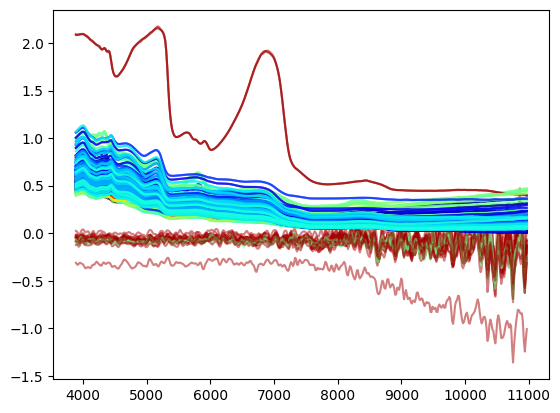

In [79]:

# data[key].iloc[:,i].name  # 'E46_res32_001_230428_104059.0002'

lines = []
    
for key in data.keys():
    
    Y = data[key].values
    ax = data[key].index
    idf = infodf[infodf['Experiment'].isin(data[key].columns)]
    for i in range(len(data[key].columns)):
        cols = infodf[infodf['Experiment']==data[key].iloc[:,i].name]["Colors"].values[0]
        line_i = plt.plot(ax, Y[:,i], c=cols, alpha=0.5)
        lines.append(line_i[0])


IndexError: single positional indexer is out-of-bounds

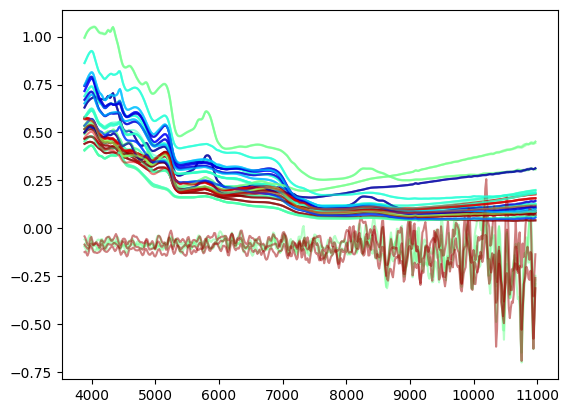

In [ ]:


# v1
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from sklearn.utils.extmath import randomized_svd

# data[key].iloc[:,i].name  # 'E46_res32_001_230428_104059.0002'

lines = []
for i in infodf.index:
    
    for key in data.keys():
        
        Y = data[key].values
        ax = data[key].index
        cols = infodf[infodf['Experiment']==data[key].iloc[:,i].name]["Colors"].values[0]
        line_i = plt.plot(ax, Y[:,i], c=cols, alpha=0.5)
        lines.append(line_i[0])
        


# myMapper = matplotlib.cm.ScalarMappable(cmap='viridis')
# colors = myMapper.to_rgba(reference)
# lines = []
# for i in range(n_series):
#     line_i = plt.plot(x, Y[:, i], color=colors[i, :])
#     lines.append(line_i[0])



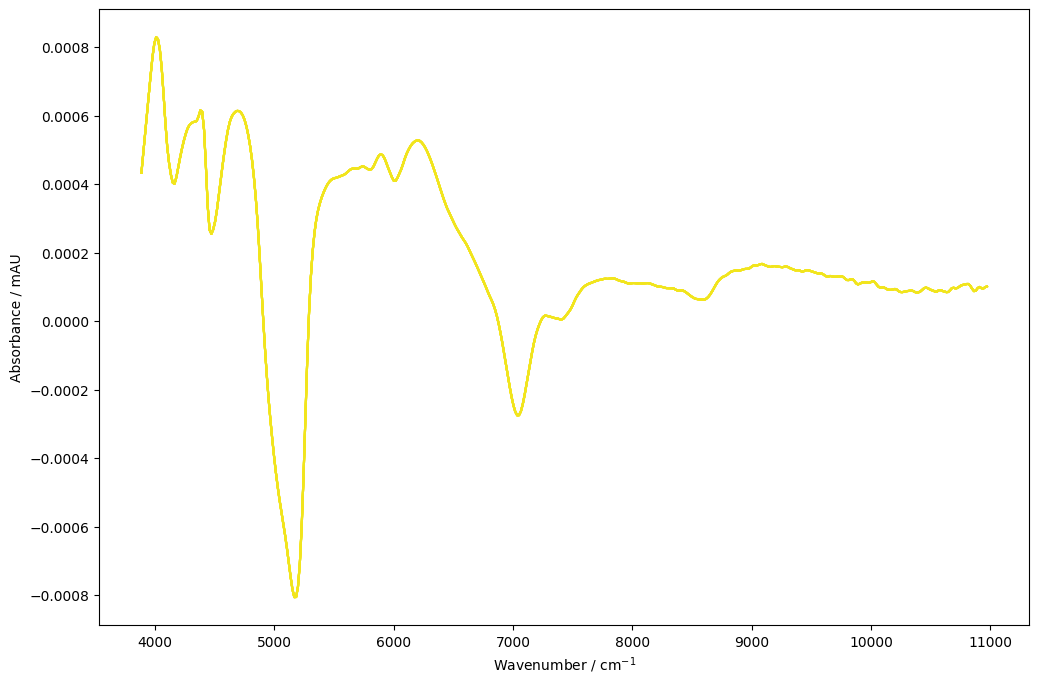

In [50]:
i=0
W = df_list[i]
X = W.iloc[:,1:].values
Y = W.iloc[:, 0].values
#wl = W.iloc[:, 0].values
X_deriv = cm.Whittaker(constraint_order = 3, deriv=2).fit_transform(X)
fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X_deriv, Y,reference=wl)
plt.xlabel(r'Wavenumber / $\mathrm{cm^{-1}}$')
plt.ylabel('Absorbance / mAU')
lines

(-0.0003, 0.0003)

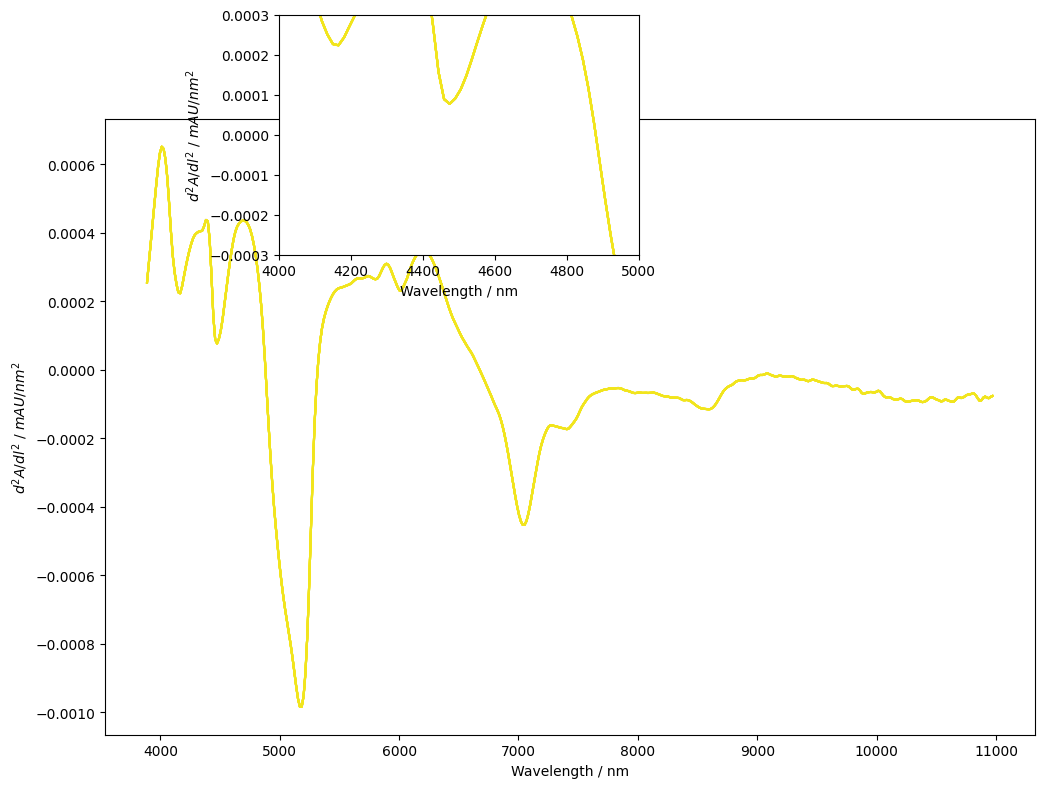

In [41]:
scaler = StandardScaler(with_std=False)

X_preprocessed = scaler.fit_transform(X_deriv)

plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X_preprocessed, Y, reference=wl)
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')

plt.axes(arg=(0.27, 0.71, 0.3, 0.3))
lines = cm.plot_colored_series(X_preprocessed, Y, reference=wl)
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')
plt.xlim([4000, 5000])
plt.ylim([-3e-4, 3e-4])

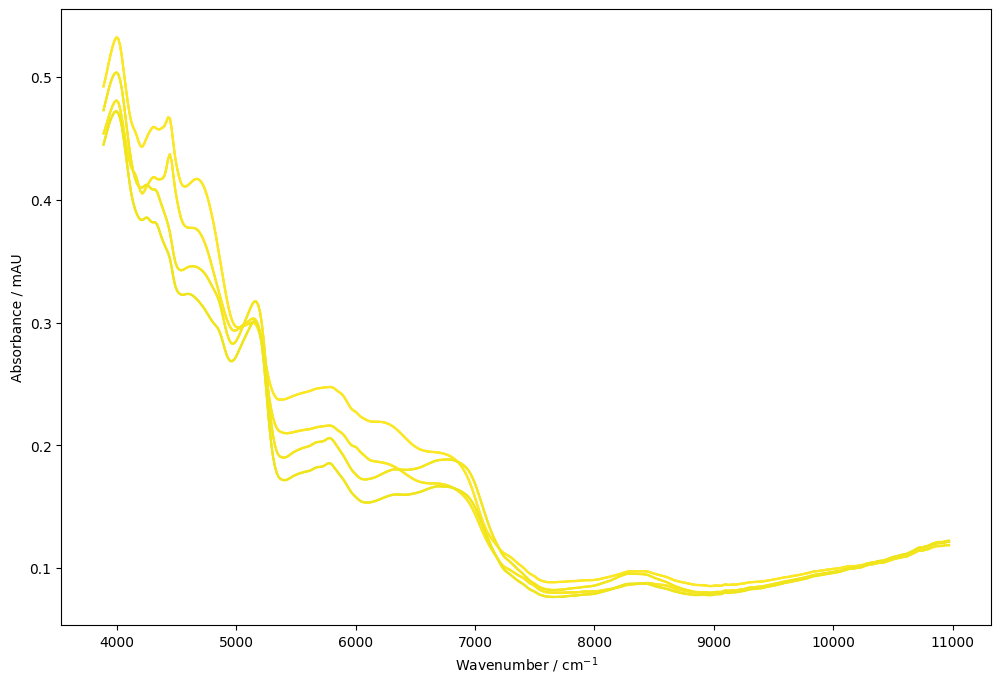

In [12]:
i=0
W = df_list[i]
X = W.iloc[:,1:].values
Y = W.iloc[:, 0].values
wl = W.iloc[:, 0].values
fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X, Y,reference=wl)
plt.xlabel(r'Wavenumber / $\mathrm{cm^{-1}}$')
plt.ylabel('Absorbance / mAU')
lines

In [136]:
url = 'https://raw.githubusercontent.com/nevernervous78/nirpyresearch/master/data/coffee_classification.csv'
coffee = pd.read_csv(url)
coffee

,Coffee Type,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,Tauro,0.948504,0.947795,0.946445,0.944988,0.943754,0.943384,0.944066,0.945799,0.948352,...,0.282806,0.281890,0.281222,0.280815,0.280693,0.280811,0.281193,0.281853,0.282838,0.284274
1,Tauro,0.905532,0.904839,0.903945,0.902695,0.901430,0.900893,0.901221,0.902677,0.904882,...,0.258335,0.257492,0.256907,0.256648,0.256645,0.256880,0.257425,0.258203,0.259317,0.260800
2,Tauro,0.784601,0.784103,0.783307,0.782516,0.781724,0.781432,0.781957,0.783278,0.785293,...,0.222330,0.221602,0.221146,0.220880,0.220885,0.221101,0.221590,0.222324,0.223326,0.224650
3,Tauro,0.720050,0.719402,0.718323,0.717160,0.716094,0.715715,0.716034,0.717204,0.718991,...,0.198238,0.197453,0.196903,0.196654,0.196652,0.196831,0.197252,0.197917,0.198817,0.200071
4,Tauro,0.820835,0.820500,0.819734,0.818661,0.817800,0.817529,0.818071,0.819510,0.821659,...,0.232847,0.232013,0.231440,0.231195,0.231231,0.231466,0.231987,0.232698,0.233674,0.234985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Calabrese,0.577826,0.577505,0.576918,0.576367,0.576137,0.576277,0.576935,0.578227,0.579890,...,0.169227,0.168720,0.168375,0.168199,0.168165,0.168292,0.168563,0.169051,0.169764,0.170806
66,Calabrese,0.572090,0.571916,0.571485,0.570920,0.570449,0.570359,0.570844,0.571766,0.573244,...,0.175791,0.175297,0.175033,0.174949,0.174988,0.175213,0.175606,0.176164,0.176921,0.177915
67,Calabrese,0.522417,0.522132,0.521493,0.520754,0.520109,0.519794,0.520116,0.520921,0.522011,...,0.158265,0.157811,0.157496,0.157363,0.157312,0.157429,0.157680,0.158116,0.158777,0.159726
68,Calabrese,0.605917,0.605510,0.605064,0.604557,0.604211,0.604338,0.605109,0.606380,0.608206,...,0.181414,0.180855,0.180472,0.180280,0.180279,0.180507,0.180897,0.181496,0.182267,0.183363


In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [80]:
colors

[(0.2751423149905123, 1.0, 0.6925996204933587, 1.0),
 (0.2751423149905123, 1.0, 0.6925996204933587, 1.0),
 (0.2751423149905123, 1.0, 0.6925996204933587, 1.0),
 (0.2877925363693864, 1.0, 0.6799493991144845, 1.0),
 (0.2877925363693864, 1.0, 0.6799493991144845, 1.0),
 (0.2877925363693864, 1.0, 0.6799493991144845, 1.0),
 (0.8743315508021392, 0.0, 0.0, 1.0),
 (0.8743315508021392, 0.0, 0.0, 1.0),
 (0.8743315508021392, 0.0, 0.0, 1.0),
 (0.8565062388591802, 0.0, 0.0, 1.0),
 (0.8565062388591802, 0.0, 0.0, 1.0),
 (0.8565062388591802, 0.0, 0.0, 1.0),
 (0.0, 0.0, 0.820855614973262, 1.0),
 (0.16129032258064513, 1.0, 0.8064516129032259, 1.0),
 (0.16129032258064513, 1.0, 0.8064516129032259, 1.0),
 (0.16129032258064513, 1.0, 0.8064516129032259, 1.0),
 (0.1865907653383934, 1.0, 0.7811511701454776, 1.0),
 (0.1865907653383934, 1.0, 0.7811511701454776, 1.0),
 (0.1865907653383934, 1.0, 0.7811511701454776, 1.0),
 (0.21189120809614148, 1.0, 0.7558507273877295, 1.0),
 (0.21189120809614148, 1.0, 0.755850727387

In [137]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,450,451,452,453,454,455,456,457,458,459
Cm-1,10970.530867,10955.101147,10939.671427,10924.241707,10908.811987,10893.382267,10877.952547,10862.522827,10847.093107,10831.663387,...,4027.156900,4011.727180,3996.297461,3980.867741,3965.438021,3950.008301,3934.578581,3919.148861,3903.719141,3888.289421
E46_res32_001_230428_104059.0000,0.121523,0.121347,0.121076,0.120820,0.120748,0.120709,0.120578,0.120285,0.119881,0.119461,...,0.525453,0.531054,0.532177,0.529657,0.525041,0.519280,0.512668,0.505547,0.498406,0.492179
E46_res32_001_230428_104059.0001,0.121405,0.121314,0.120975,0.120503,0.120305,0.120303,0.120157,0.119766,0.119382,0.119086,...,0.525518,0.531167,0.532338,0.529837,0.525198,0.519421,0.512835,0.505721,0.498557,0.492350
E46_res32_001_230428_104059.0002,0.121640,0.121452,0.121084,0.120659,0.120461,0.120418,0.120366,0.120163,0.119799,0.119355,...,0.525636,0.531276,0.532435,0.529909,0.525263,0.519507,0.512946,0.505867,0.498740,0.492527
E47_res32_001_230428_105353.0000,0.121868,0.121796,0.121387,0.120852,0.120614,0.120675,0.120683,0.120337,0.119797,0.119271,...,0.474175,0.479232,0.480794,0.479535,0.476704,0.472979,0.468480,0.463461,0.458382,0.453972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E098_230612_134546.0001,0.063586,0.060386,0.057953,0.057704,0.058691,0.059455,0.059496,0.059520,0.059651,0.059527,...,0.549577,0.555185,0.556579,0.554575,0.550699,0.545709,0.539878,0.533669,0.527547,0.522365
E098_230612_134546.0002,0.063194,0.060514,0.058589,0.058680,0.059890,0.060459,0.059703,0.058919,0.058958,0.058933,...,0.550336,0.555756,0.556837,0.554629,0.550786,0.546074,0.540593,0.534620,0.528580,0.523259
E099_230612_102805.0000,0.162471,0.160218,0.158070,0.157194,0.157546,0.158213,0.157848,0.156641,0.155562,0.154392,...,0.773620,0.781278,0.784005,0.782611,0.778624,0.773037,0.766364,0.759134,0.751772,0.745284
E099_230612_102805.0001,0.159963,0.156927,0.154932,0.155207,0.156293,0.155974,0.154056,0.152516,0.152254,0.151671,...,0.774130,0.782141,0.784861,0.783296,0.779379,0.774019,0.767266,0.759616,0.751993,0.745581


In [ ]:
info = {'Experiment': df.columns[1:]}
infodf = pd.DataFrame(info)
infodf['Group'] = infodf.Experiment.str.split("_").str[0]
labels = infodf['Group']
y = LabelEncoder().fit_transform(labels)
# X = -np.log(df.values[:,1:].T)
X = df.values.astype('float32').T


array([0.121523, 0.121347, 0.121076, ..., 0.759932, 0.752301, 0.74558 ],
      dtype=float32)

In [207]:
# Xn = np.nan_to_num(X, copy=False)
Xc = X - X.mean(axis=0)
X1 = cm.Whittaker(constraint_order=3, deriv=2).fit_transform(X)
w = X[0,:]
wl = df.iloc[:,0]
wl = np.linspace(max(w), min(w), X.shape[1])


In [214]:
print(X1.shape)
print(wl.shape)
print(X[1:].shape)
rows = np.where(X> 1)


(964, 458)
(460,)
(963, 460)


array([0.121523, 0.121347, 0.121076, ..., 0.759932, 0.752301, 0.74558 ],
      dtype=float32)

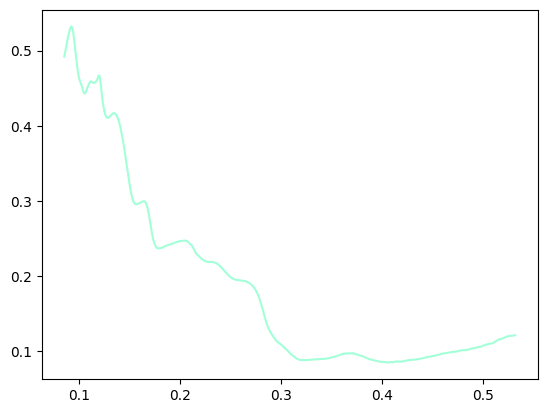

In [202]:
plt.plot(wl, X[0,:], c = (0.2751423149905123, 1.0, 0.6925996204933587, 1.0), alpha=0.5)

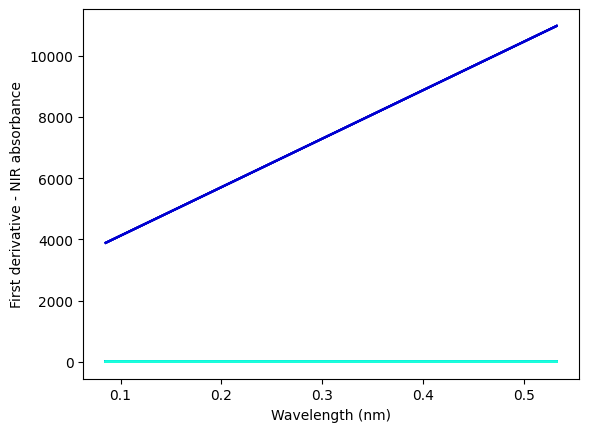

In [206]:

colors = [plt.cm.jet(float(i)/max(y)) for i in y]
for i,j in enumerate(colors):
    plt.plot(wl, X[i,:], c=j, alpha=0.5)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('First derivative - NIR absorbance')
plt.show()

In [ ]:
import spectral.io.aviris as aviris